In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc



In [2]:
df_train = pd.read_csv('train (1).csv')
df_test = pd.read_csv('test.csv')
df_test_lab = pd.read_csv('test_labels.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
df_test_lab.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
df_train.shape


(159571, 8)

In [9]:
df_test.shape


(153164, 2)

In [10]:
df_test_lab.shape

(153164, 7)

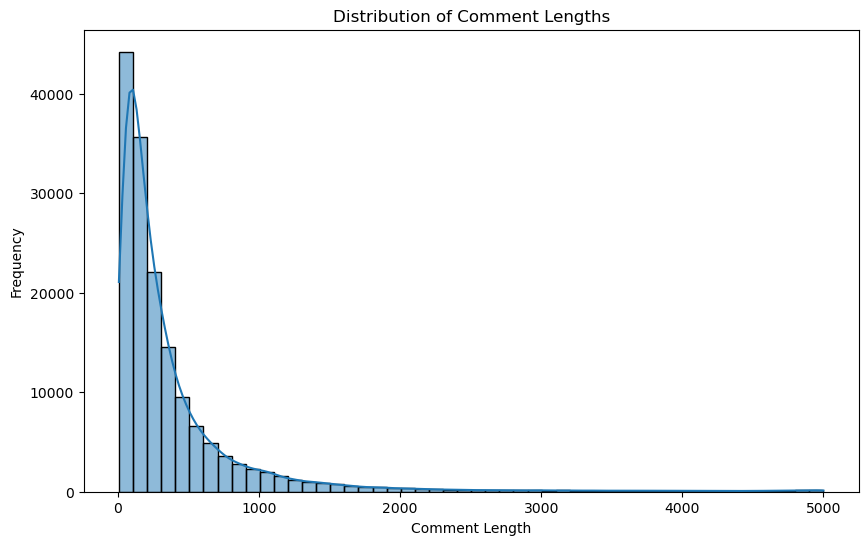

In [11]:
df_train['comment_length'] = df_train['comment_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='comment_length', bins=50, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

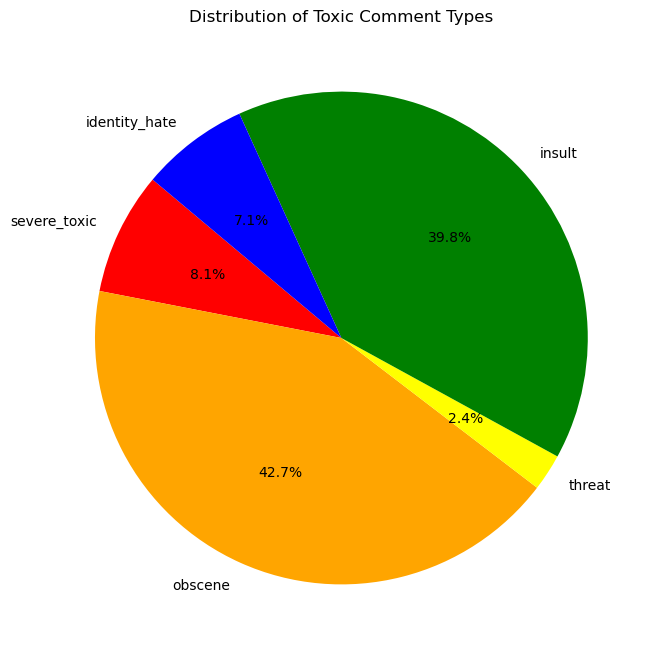

In [12]:
types = df_train[['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
plt.figure(figsize=(10, 8))
plt.pie(types, labels=types.index, autopct='%1.1f%%', startangle=140, colors=['red', 'orange', 'yellow', 'green', 'blue'])
plt.title('Distribution of Toxic Comment Types')
plt.show()


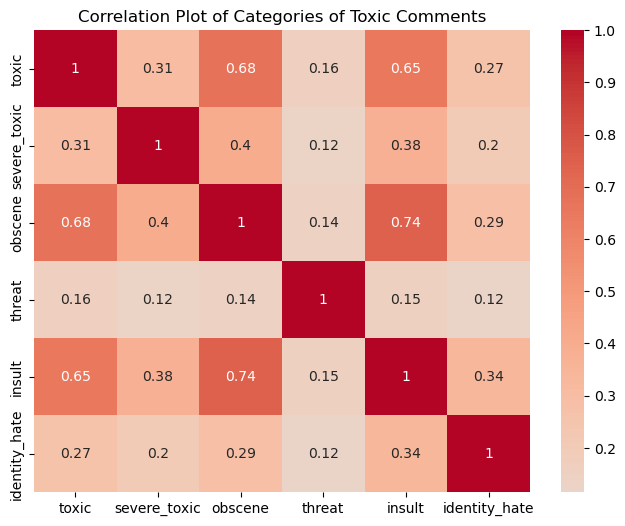

In [42]:
#Correlation
correlation_matrix = df_train[:-1].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Plot of Categories of Toxic Comments')
plt.show()

In [14]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
def clean_text(text):
    
    #Change the text in lower case
    text = text.lower()
    
    #Cleaning text
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    #Tokenizing words
    text = word_tokenize(text) 
    
    # remove any non ascii
    text = [word.encode('ascii', 'ignore').decode('ascii') for word in text]
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(w) for w in text]
    text = [w for w in text if len(w) > 2]
    
    #Removing Stop words
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    
    #Joining words to a single string
    cleaned_text = ' '.join(text)

    return cleaned_text  




[nltk_data] Downloading package omw-1.4 to C:\Users\Shruti
[nltk_data]     Sontakke\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
df_train = pd.read_csv('train (1).csv')
df_train['cleaned_text'] = df_train['comment_text'].map(lambda com : clean_text(com))


In [16]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wondered sect...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


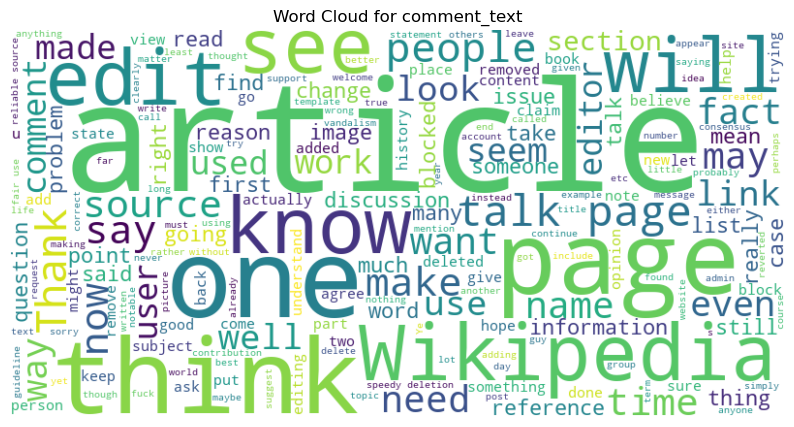

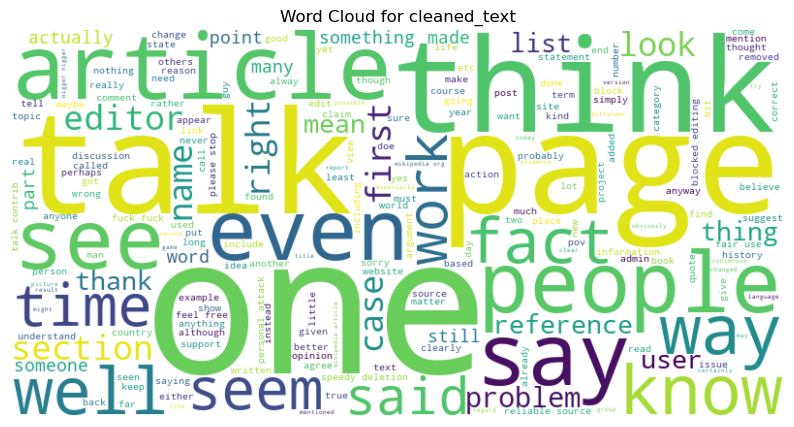

In [17]:
#WordCloud
# List of text-based columns you want to create word clouds for
text_columns = ['comment_text', 'cleaned_text']  # Add more text-based columns if needed

# Generate and display word clouds for text-based columns
for column in text_columns:
    text = ' '.join(df_train[column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()

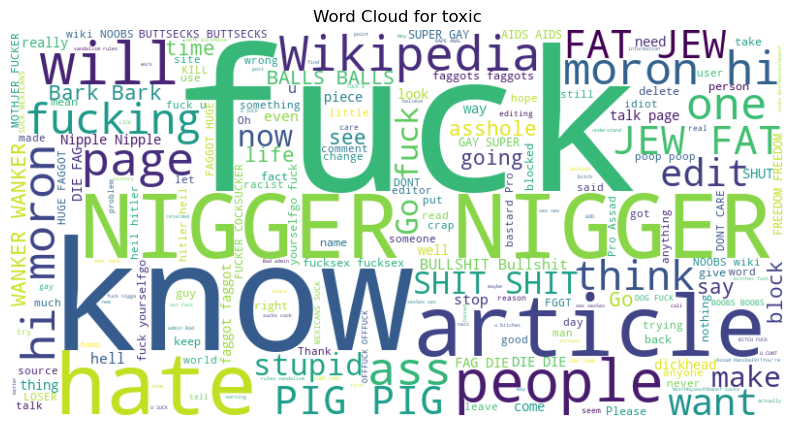

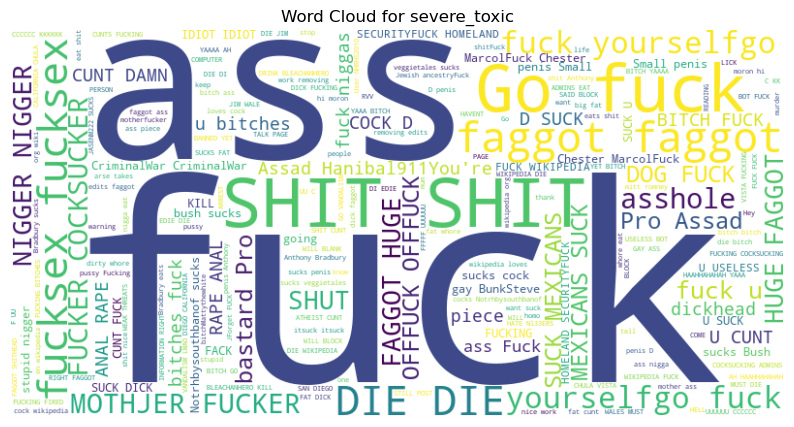

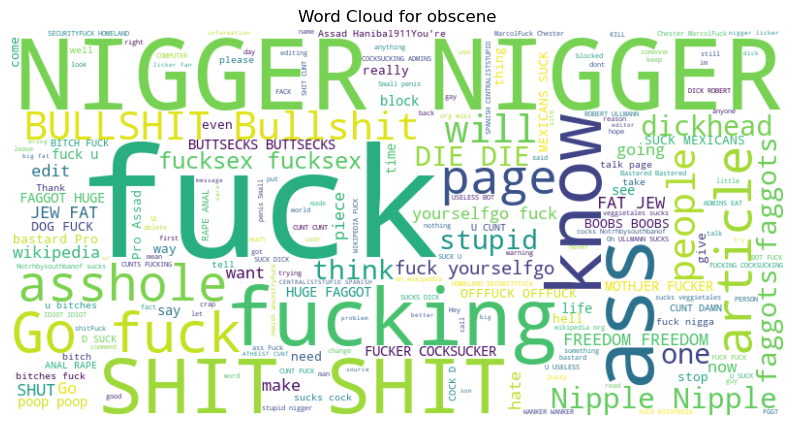

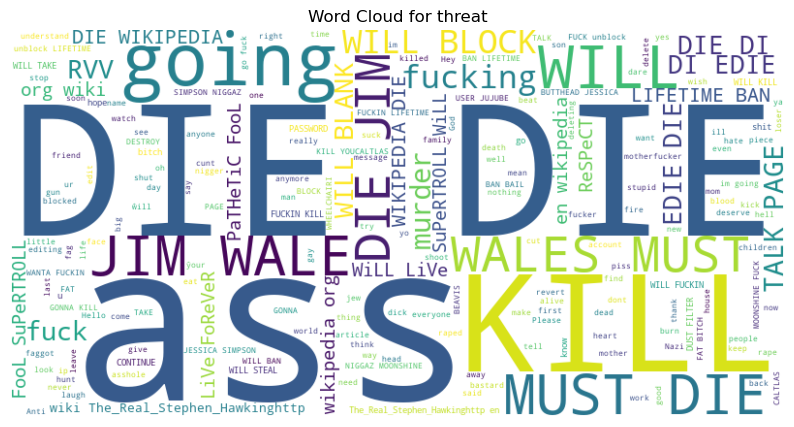

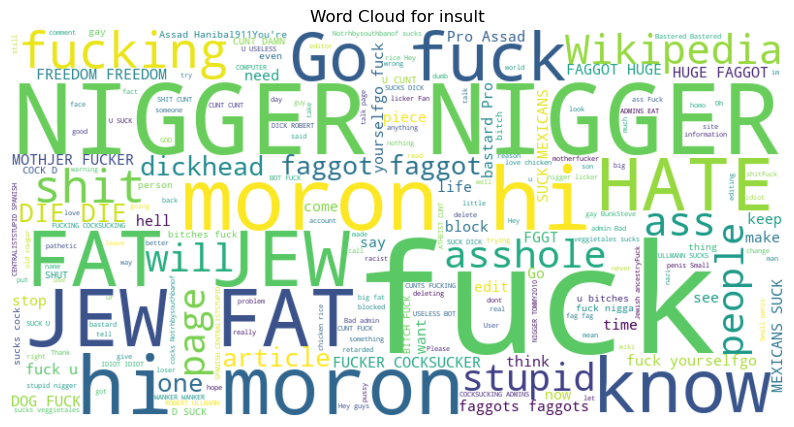

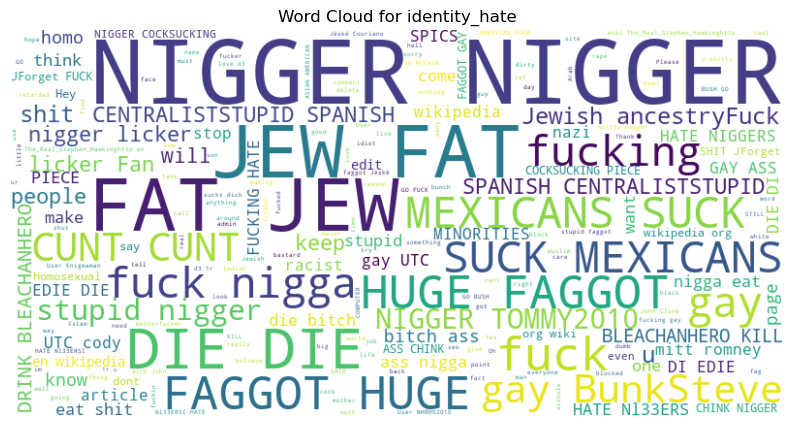

In [18]:
# Columns to create word clouds for
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Generate and display word clouds for each column
for column in COLUMNS:
    # Combine all comments in the column into a single text
    text = ' '.join(df_train[df_train[column] == 1]['comment_text'])
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()

In [19]:
#Feature Extraction using TF-IDF vectorization

df_labeled = df_train['cleaned_text']
y = df_train['toxic']
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_labeled)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [21]:
# Training a Logistic Regression classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.9576688077706408

Confusion Matrix:
 [[28664   195]
 [ 1156  1900]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.62      0.74      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915



In [22]:
#Training an XGB Classifier
model1 = xgb.XGBClassifier()
model1.fit(X_train, y_train)

# Make predictions on the test set
y1_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y1_pred)
conf_matrix = confusion_matrix(y_test, y1_pred)
classification_rep = classification_report(y_test, y1_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.955193482688391

Confusion Matrix:
 [[28657   202]
 [ 1228  1828]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.90      0.60      0.72      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915



In [27]:
# Training SVM classifier
model2 = SVC(kernel='linear')  # You can choose different kernel types as needed
model2.fit(X_train, y_train)

# Make predictions on the test set
y_pred2 = model2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred2)
conf_matrix = confusion_matrix(y_test, y_pred2)
classification_rep = classification_report(y_test, y_pred2)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.9587968040106533

Confusion Matrix:
 [[28611   248]
 [ 1067  1989]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.89      0.65      0.75      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.82      0.86     31915
weighted avg       0.96      0.96      0.96     31915



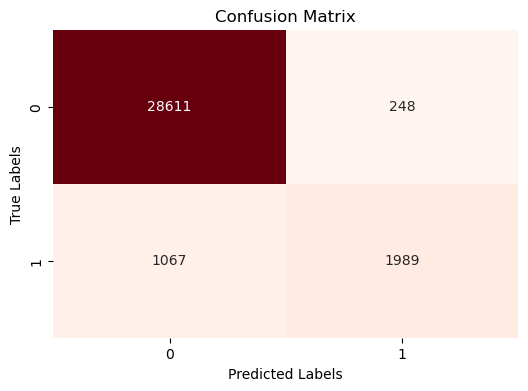

In [33]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.62      0.74      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915



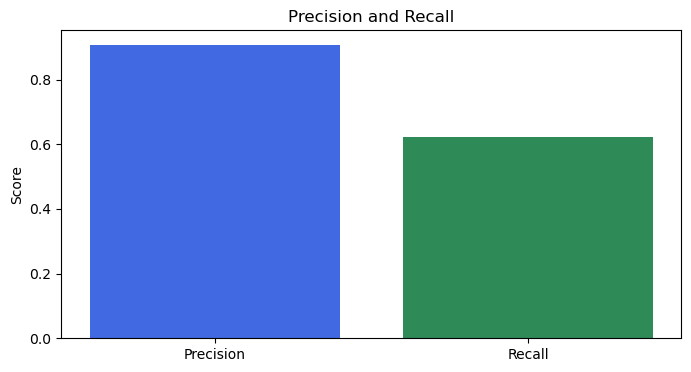

In [37]:
# Print classification report (precision, recall, F1-score)
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

# Visualize precision and recall
precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
plt.figure(figsize=(8, 4))
plt.bar(['Precision', 'Recall'], [precision, recall], color=['royalblue', 'seagreen'])
plt.ylabel('Score')
plt.title('Precision and Recall')

plt.show()

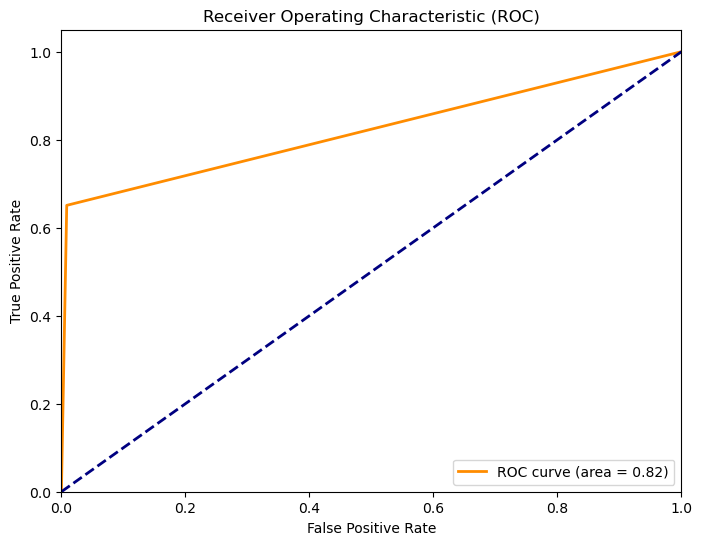

AUC (Area Under the Curve): 0.82


In [38]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred2)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print AUC score
print("AUC (Area Under the Curve): {:.2f}".format(roc_auc))

In [39]:
#Make prediction on the entire dataset
y_pred3 = model2.predict(X_tfidf)

In [46]:
# Add the predicted sentiment labels to the DataFrame
df_train['predicted_sentiment'] = y_pred3

In [47]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text,predicted_sentiment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stuck th...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wondered sect...,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page,0
